# Growing Neural Cellular Automata with Evolution Strategies [![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/maxencefaldor/cax/blob/main/examples/40_growing_nca.ipynb)

## Installation

You will need Python 3.10 or later, and a working JAX installation. For example, you can install JAX with:

In [ ]:
%pip install -U "jax[cuda12]"

Then, install CAX from PyPi:

In [ ]:
%pip install -U "cax[examples]"

In [ ]:
%pip install -U evosax

## Import

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import mediapy
import optax
import PIL
from flax import nnx
from tqdm.auto import tqdm

from cax.core import CA
from cax.core.perceive import ConvPerceive, grad_kernel, identity_kernel
from cax.core.update import NCAUpdate
from cax.utils import clip_and_uint8, get_emoji, rgba_to_rgb

## Configuration

In [3]:
seed = 0

channel_size = 16
num_kernels = 3
hidden_size = 128
cell_dropout_rate = 0.5

num_generations = 8_192
population_size = 256
batch_size = 1
num_steps = 64

emoji = "🦎"
size = 40
pad_width = 4

key = jax.random.key(seed)
rngs = nnx.Rngs(seed)

## Dataset

""

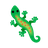

In [4]:
def get_y_from_emoji(emoji: str) -> jax.Array:
	"""Get target y from an emoji."""
	emoji_pil = get_emoji(emoji)
	emoji_pil = emoji_pil.resize((size, size), resample=PIL.Image.Resampling.LANCZOS)

	y = jnp.array(emoji_pil, dtype=jnp.float32) / 255.0
	y = jnp.pad(y, ((pad_width, pad_width), (pad_width, pad_width), (0, 0)))

	return y


y = get_y_from_emoji(emoji)

mediapy.show_image(y)

## Model

In [5]:
perceive = ConvPerceive(
	channel_size=channel_size,
	perception_size=num_kernels * channel_size,
	rngs=rngs,
	feature_group_count=channel_size,
)
update = NCAUpdate(
	channel_size=channel_size,
	perception_size=num_kernels * channel_size,
	hidden_layer_sizes=(hidden_size,),
	rngs=rngs,
	cell_dropout_rate=cell_dropout_rate,
	zeros_init=True,
)

In [6]:
class GrowingNCA(CA):
	"""Growing Neural Cellular Automata."""

	def __init__(self, perceive, update):
		"""Initialize Growing NCA."""
		super().__init__(perceive, update)

		# Initialize kernel with sobel filters
		kernel = jnp.concatenate([identity_kernel(ndim=2), grad_kernel(ndim=2)], axis=-1)
		kernel = jnp.expand_dims(jnp.concatenate([kernel] * channel_size, axis=-1), axis=-2)
		self.perceive.conv.kernel = nnx.Param(kernel)

	@nnx.jit
	def render(self, state):
		"""Render state to RGB."""
		rgba = state[..., -4:]
		rgb = rgba_to_rgb(rgba)

		# Clip values to valid range and convert to uint8
		return clip_and_uint8(rgb)

	@nnx.jit
	def render_rgba(self, state):
		"""Render state to RGBA."""
		rgba = state[..., -4:]

		# Clip values to valid range and convert to uint8
		return clip_and_uint8(rgba)

In [7]:
ca = GrowingNCA(perceive, update)

In [8]:
params = nnx.state(ca, nnx.Param)
print("Number of params:", sum(x.size for x in jax.tree.leaves(params)))

Number of params: 8768


## Sample initial state

In [9]:
def sample_state():
	"""Sample a state with a single alive cell."""
	spatial_dims = y.shape[:2]

	# Init state
	state = jnp.zeros(spatial_dims + (channel_size,))

	# Set the center cell to alive
	mid = tuple(size // 2 for size in spatial_dims)
	return state.at[mid[0], mid[1], -1].set(1.0)

## Train

### Evolution Strategy

In [ ]:
from evosax.algorithms import PGPE as ES

In [10]:
from evosax.algorithms import Open_ES as ES

trainable_filter = nnx.All(nnx.Param, nnx.PathContains("update"))
solution = nnx.state(ca, trainable_filter)

learning_rate = 0.001
std_init = 0.001
std_final = 0.0001
std_schedule = optax.linear_schedule(
    init_value=std_init,
    end_value=std_final,
    transition_steps=num_generations
)

es = ES(
	population_size=population_size,
	solution=solution,
    optimizer=optax.adam(learning_rate=learning_rate),
    std_schedule=optax.constant_schedule(std_init),
)

es_params = es.default_params

In [11]:
key, subkey = jax.random.split(key)
es_state = es.init(subkey, solution, es_params)

### Loss

In [12]:
def mse(state):
	"""Mean Squared Error."""
	return jnp.mean(jnp.square(state[..., -4:] - y))

In [13]:
@nnx.jit
def loss_fn(ca, state, key):
	"""Loss function."""
	state_axes = nnx.StateAxes({nnx.RngState: 0, ...: None})
	state, _ = nnx.split_rngs(splits=batch_size)(
		nnx.vmap(
			lambda ca, state: ca(state, num_steps=num_steps),
			in_axes=(state_axes, None),
		)
	)(ca, state)

	loss = mse(state)
	return loss

### Train step

In [14]:
@nnx.jit
def train_step(ca, es_state, key):
	key, key_ask, key_eval, key_tell = jax.random.split(key, 4)

	state = sample_state()

	# Generate a set of candidate solutions to evaluate
	population, es_state = es.ask(key_ask, es_state, es_params)

	# Evaluate the fitness of the population
	nnx.update(ca, population)

	state_axes = nnx.StateAxes({trainable_filter: 0, ...: None})
	fitness = nnx.vmap(
		loss_fn,
		in_axes=(state_axes, None, None),
	)(ca, state, key_eval)
	loss = jnp.mean(fitness)

	# Update the evolution strategy
	es_state, metrics = es.tell(key_tell, population, fitness, es_state, es_params)

	return es_state, loss, metrics

### Main loop

In [ ]:
num_generations = 16384
print_interval = 128

pbar = tqdm(range(num_generations), desc="Evolution", unit="generation")
losses = []
for i in pbar:
	key, subkey = jax.random.split(key)
	es_state, loss, metrics = train_step(ca, es_state, subkey)
	losses.append(loss)

	if i % print_interval == 0 or i == num_generations - 1:
		avg_loss = sum(losses[-print_interval:]) / len(losses[-print_interval:])
		pbar.set_postfix({"Average Loss": f"{avg_loss:.3e}"})

Evolution:   0%|          | 0/16384 [00:00<?, ?generation/s]

In [37]:
trainable_params = es.get_mean(es_state)
nnx.update(ca, trainable_params)

## Run

In [18]:
num_examples = 8

state_init = jax.vmap(lambda _: sample_state())(jnp.zeros(num_examples))

state_axes = nnx.StateAxes({nnx.RngState: 0, ...: None})
state_final, states = nnx.split_rngs(splits=num_examples)(
	nnx.vmap(
		lambda ca, state_init: ca(state_init, num_steps=2 * num_steps),
		in_axes=(state_axes, 0),
	)
)(ca, state_init)

## Visualize

,,,,,,,

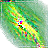
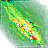
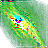
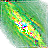
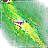
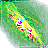
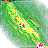
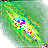

,,,,,,,

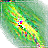
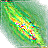
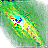
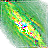
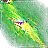
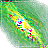
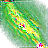
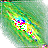

In [19]:
frames_final = nnx.vmap(
	lambda ca, state: ca.render(state),
	in_axes=(None, 0),
)(ca, state_final)
frames_final_rgba = nnx.vmap(
	lambda ca, state: ca.render_rgba(state),
	in_axes=(None, 0),
)(ca, state_final)

mediapy.show_images(frames_final, width=128, height=128)
mediapy.show_images(frames_final_rgba, width=128, height=128)

,,,,,,,

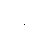
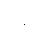
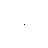
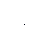
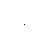
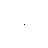
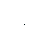
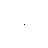

In [20]:
states = jnp.concatenate([state_init[:, None], states], axis=1)
frames = nnx.vmap(
	lambda ca, states: ca.render(states),
	in_axes=(None, 0),
)(ca, states)

mediapy.show_videos(frames, width=128, height=128, codec="gif")